In [1]:
import base64
import functools
from io import BytesIO
import os
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, RDLogger, RDPaths
RDLogger.DisableLog('rdApp.error')
from rdkit.Chem import AllChem, DataStructs, Draw, rdBase, rdCoordGen, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D, SimilarityMaps
from rdkit.ML.Descriptors import MoleculeDescriptors
print(f'RDKit: {rdBase.rdkitVersion}')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import shap
print(f'SHAP: {shap.__version__}')

RDKit WARNING: [22:57:51] Enabling RDKit 2019.09.1 jupyter extensions


RDKit: 2019.09.1
SHAP: 0.34.0


In [2]:
sns.set_style("whitegrid")

In [3]:
shap.initjs()

## Function Settings

In [4]:
# from chainer-chemistry's visualizer_utils.py
def red_blue_cmap(x):
    """Red to Blue color map
    Args:
        x (float): value between -1 ~ 1, represents normalized saliency score
    Returns (tuple): tuple of 3 float values representing R, G, B.
    """
    if x > 0:
        # Red for positive value
        # x=0 -> 1, 1, 1 (white)
        # x=1 -> 1, 0, 0 (red)
        return 1.0, 1.0 - x, 1.0 - x
    else:
        # Blue for negative value
        x *= -1
        return 1.0 - x, 1.0 - x, 1.0

def is_visible(begin, end):
    if begin <= 0 or end <= 0:
        return 0
    elif begin >= 1 or end >= 1:
        return 1
    else:
        return (begin + end) * 0.5
    
def color_bond(bond, saliency, color_fn):
    begin = saliency[bond.GetBeginAtomIdx()]
    end = saliency[bond.GetEndAtomIdx()]
    return color_fn(is_visible(begin, end))

In [5]:
def moltopng(mol, atom_colors, bond_colors, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(atom_colors))], 
        highlightAtomColors=atom_colors, 
        highlightBonds=[i for i in range(len(bond_colors))],
        highlightBondColors=bond_colors,
        highlightAtomRadii={i: .5 for i in range(len(atom_colors))}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def label_cat(label):
    return '$+$' if bool(label!=0) else '$\cdot$'

In [6]:
# https://iwatobipen.wordpress.com/2017/02/25/draw-molecule-with-atom-index-in-rdkit/
def mol_with_atom_index(mol):
    import copy
    atoms = mol.GetNumAtoms()
    molwithidx = copy.deepcopy(mol)
    for idx in range( atoms ):
        molwithidx.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( molwithidx.GetAtomWithIdx( idx ).GetIdx() ) )
    return molwithidx

In [7]:
def draw_mols_with_idx(mol, atom_colors, bond_colors):
    images = []
    _img = moltopng(mol, atom_colors, bond_colors, molSize=(720, 480))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 720px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")
    _img = moltopng(mol_with_atom_index(mol), {}, {}, molSize=(720, 470))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 720px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")

    images = ''.join(images)
    display(HTML(images))

In [8]:
def plot_explainable_images(mol: rdkit.Chem.Mol, weight_fn, weights=None, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br']):
    symbols = [f'{mol.GetAtomWithIdx(i).GetSymbol()}_{i}' for i in range(mol.GetNumAtoms())]
    df = pd.DataFrame(columns=atoms)
    if weights is None:
        contribs = weight_fn(mol)
    else:
        contribs = weights
    num_atoms = mol.GetNumAtoms()
    arr = np.zeros((num_atoms, len(atoms)))
    for i in range(mol.GetNumAtoms()):
        _a = mol.GetAtomWithIdx(i).GetSymbol()
        arr[i,atoms.index(_a)] = contribs[i]
    df = pd.DataFrame(arr, index=symbols, columns=atoms)
    weights, vmax = SimilarityMaps.GetStandardizedWeights(contribs)
    vmin = -vmax
    atom_colors = {i: red_blue_cmap(e) for i, e in enumerate(weights)}
    # bondlist = [bond.GetIdx() for bond in mol.GetBonds()]
    bond_colors = {i: color_bond(bond, weights, red_blue_cmap) for i, bond in enumerate(mol.GetBonds())}
    draw_mols_with_idx(mol, atom_colors, bond_colors)
    
    fig = plt.figure(figsize=(18, 9))
    grid = plt.GridSpec(15, 10)
    ax = fig.add_subplot(grid[1:, -1])
    ax.barh(range(mol.GetNumAtoms()), np.maximum(0, df.values).sum(axis=1), color='C3')
    ax.barh(range(mol.GetNumAtoms()), np.minimum(0, df.values).sum(axis=1), color='C0')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(-.5, mol.GetNumAtoms()-.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, labelleft=False)

    ax = fig.add_subplot(grid[1:, :-1], sharey=ax)
    im = ax.imshow(df.values, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(mol.GetNumAtoms() -.5, -.5)
    symbols= {i: f'${mol.GetAtomWithIdx(i).GetSymbol()}_{{{i}}}$' for i in range(mol.GetNumAtoms())}
    ax.set_yticklabels(symbols.values())
    ax.set_xticks(range(len(atoms)))

    ax.set_xlim(-.5, len(atoms) -.5)
    ax.set_xticklabels(atoms, rotation=90)
    ax.set_ylabel('Node')

    for (j,i),label in np.ndenumerate(df.values):
        ax.text(i,j, label_cat(label) ,ha='center',va='center')
    ax.tick_params(axis='both', which='both', bottom=True, labelbottom=True, top=False, labeltop=False)
    ax.grid(b=None)


    ax = fig.add_subplot(grid[0, :-1])
    fig.colorbar(mappable=im, cax=ax, orientation='horizontal')
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, top=True, labeltop=True)

    display(fig)
    plt.close(fig)

## Training Random Forest Model

In [9]:
# https://iwatobipen.wordpress.com/2018/11/07/visualize-important-features-of-machine-leaning-rdkit/

def mol2fp(mol,radius=2, nBits=1024):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo

train_path = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
test_path = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')
train_mols = Chem.SDMolSupplier(train_path)
test_mols = Chem.SDMolSupplier(test_path)
print(len(train_mols), len(test_mols))

sol_classes = {'(A) low': 0, '(B) medium': 1, '(C) high': 2}
X_train = np.array([mol2fp(m)[0] for m in train_mols])
y_train = np.array([sol_classes[m.GetProp('SOL_classification')] for m in train_mols], dtype=np.int) 
X_test = np.array([mol2fp(m)[0] for m in test_mols])
y_test = np.array([sol_classes[m.GetProp('SOL_classification')] for m in test_mols], dtype=np.int)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

clf = RandomForestClassifier(random_state=20191215)
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))

1025 257
(1025, 1024) (1025,) (257, 1024) (257,)
0.6536964980544747


In [10]:
# Testにのみあるbit
only_test_bits = np.array(range(1024))[~np.any(X_train, axis=0) & np.any(X_test, axis=0)]
only_test_bits

array([215, 223, 462, 618, 818, 856])

In [11]:
# Testにのみあるbitを含む分子
X_test_with_only_test_bits = X_test[:, only_test_bits]
np.array(range(len(X_test)))[np.any(X_test_with_only_test_bits, axis=1)]

array([142, 199, 220, 243, 247, 251, 254])

## GetAtomicWeightsForModel

In [12]:
def get_proba(fp, proba_fn, class_id):
    return proba_fn((fp,))[0][class_id]

# デフォルトでGetMorganFingerprintの引数が2048ビットになっているため
def fp_partial(nBits):
    return functools.partial(SimilarityMaps.GetMorganFingerprint, nBits=nBits)

def show_pred_results(mol, model):
    y_pred = model.predict(mol2fp(mol)[0].reshape((1,-1)))
    sol_dict = {val: key for key, val in sol_classes.items()}
    print(f"True: {mol.GetProp('SOL_classification')} vs Predicted: {sol_dict[y_pred[0]]}")


True: (C) high vs Predicted: (C) high


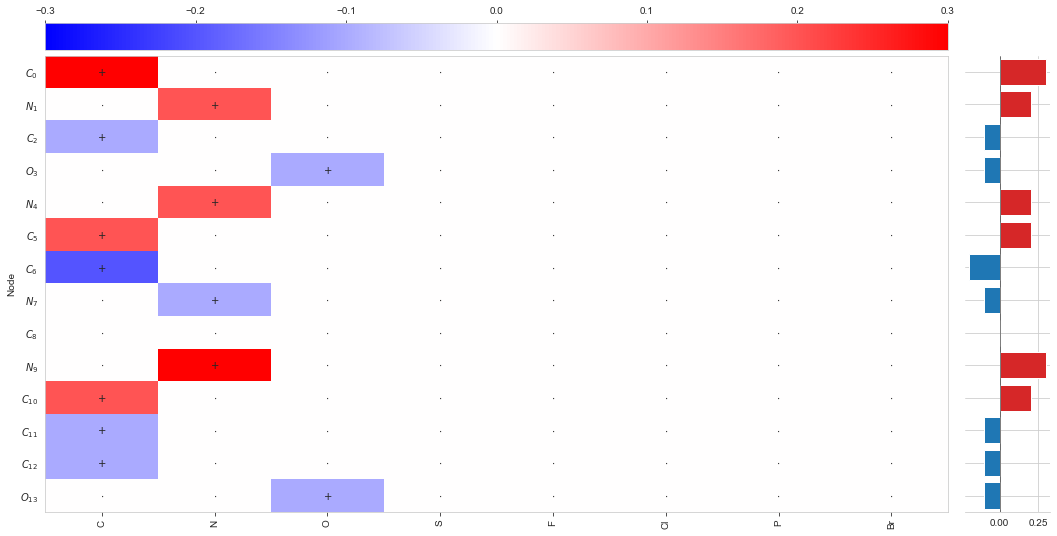

In [13]:
mol = test_mols[141]
show_pred_results(mol, clf)
weights = SimilarityMaps.GetAtomicWeightsForModel(mol, fp_partial(1024), lambda x: get_proba(x, clf.predict_proba, 2))
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

True: (C) high vs Predicted: (C) high


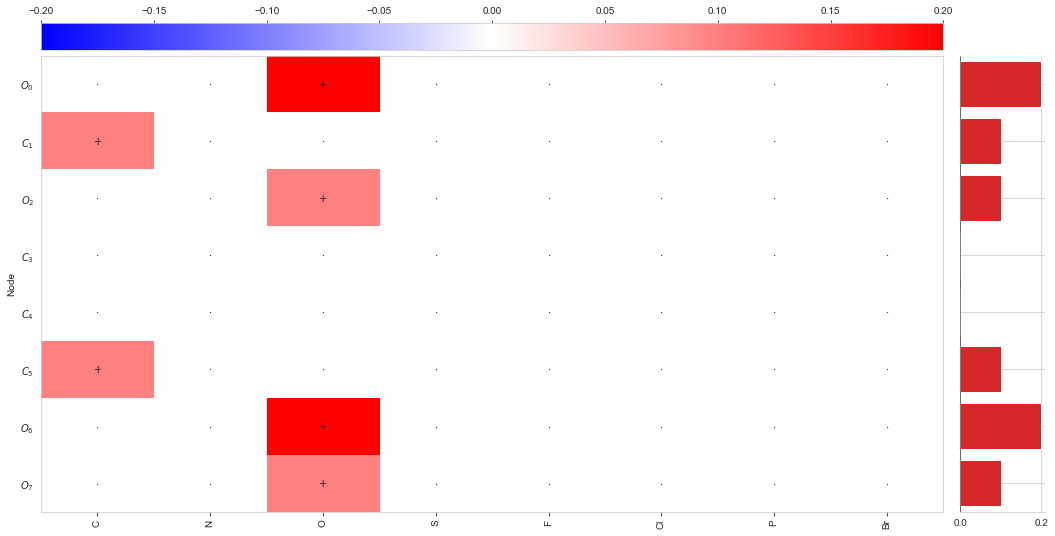

In [14]:
mol = test_mols[79]
show_pred_results(mol, clf)
weights = SimilarityMaps.GetAtomicWeightsForModel(mol, fp_partial(1024), lambda x: get_proba(x, clf.predict_proba, 2))
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

## Feature Importance

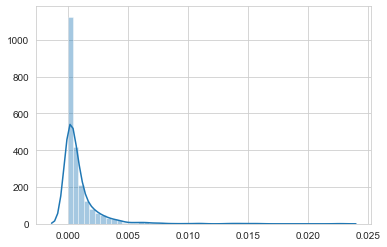

In [15]:
sns.distplot(clf.feature_importances_)
plt.show()

In [16]:
def weights_from_feat_imp(mol, feature_importance, collided_bits='mean'):
    fp, bitinfo = mol2fp(mol)
    weights = np.zeros(mol.GetNumAtoms(), ) 
    for bit, infos in bitinfo.items():
        for atom_infos in infos:            
            if collided_bits == 'mean':
                weights[atom_infos[0]] += feature_importance[bit]/ len(infos)
            else:
                weights[atom_infos[0]] += feature_importance[bit]
    return weights

In [17]:
mol2fp(test_mols[141], radius=2)[1]

{0: ((4, 2),),
 33: ((0, 0), (5, 0), (10, 0), (6, 2)),
 121: ((0, 1), (5, 1), (10, 1)),
 179: ((7, 2),),
 234: ((1, 2),),
 283: ((12, 2),),
 314: ((3, 1), (13, 1)),
 330: ((11, 2),),
 356: ((2, 0), (6, 0), (11, 0), (12, 0)),
 378: ((7, 0),),
 385: ((9, 1),),
 400: ((2, 2),),
 416: ((11, 1),),
 428: ((7, 1),),
 463: ((9, 2),),
 493: ((8, 2),),
 504: ((12, 1),),
 564: ((4, 1), (1, 1)),
 650: ((3, 0), (13, 0)),
 672: ((6, 1),),
 771: ((2, 1),),
 849: ((8, 0),),
 932: ((8, 1),),
 935: ((1, 0), (4, 0), (9, 0))}

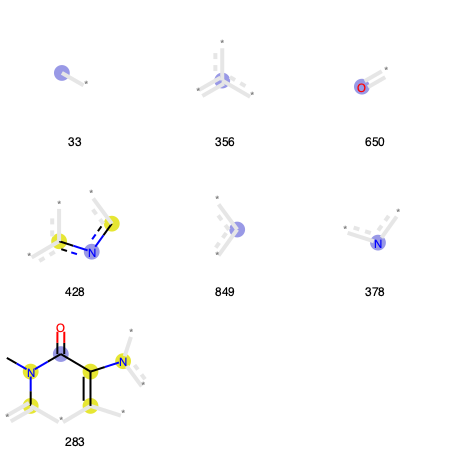

In [18]:
# https://iwatobipen.wordpress.com/2018/11/07/visualize-important-features-of-machine-leaning-rdkit/
fimportance_dict = dict(zip(range(1024), clf.feature_importances_))
sorteddata = sorted(fimportance_dict.items(), key=lambda x:-x[1])
top50feat = [x[0] for x in sorteddata][:50]

fp, bitinfo = mol2fp(test_mols[141])
onbit = [bit for bit in bitinfo.keys()]
importantonbits = list(set(onbit) & set(top50feat))

tpls = [(test_mols[141], x, bitinfo) for x in importantonbits]
Draw.DrawMorganBits(tpls, legends = [str(x) for x in importantonbits])

True: (C) high vs Predicted: (C) high


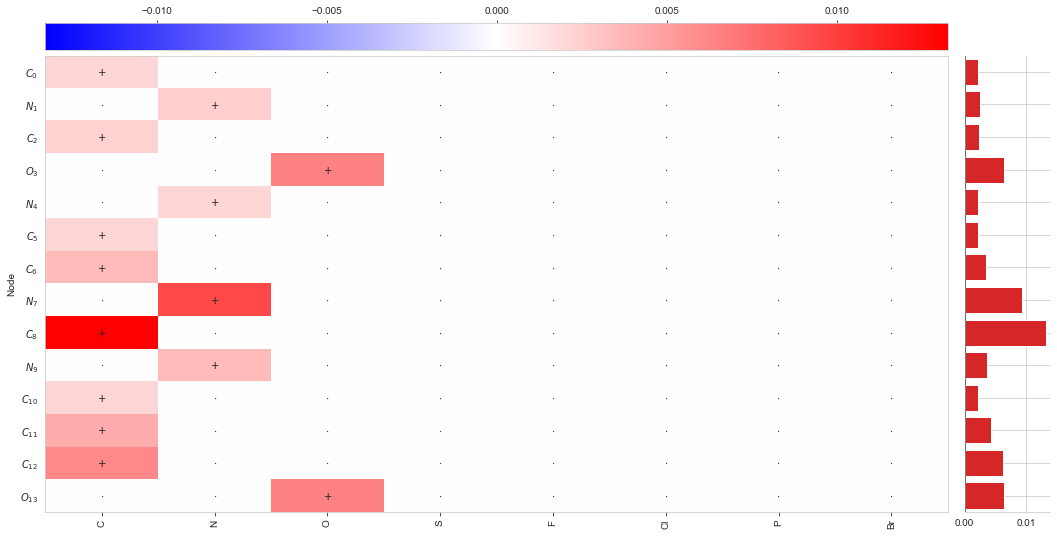

In [19]:
mol = test_mols[141]
show_pred_results(mol, clf)
weights = weights_from_feat_imp(mol, clf.feature_importances_, collided_bits='mean')
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

In [20]:
mol2fp(test_mols[79], radius=2)[1]

{80: ((3, 0), (4, 0)),
 232: ((3, 2), (4, 2)),
 263: ((1, 2), (5, 2)),
 389: ((2, 1), (7, 1)),
 540: ((3, 1), (4, 1)),
 650: ((0, 0), (6, 0)),
 713: ((1, 1), (5, 1)),
 807: ((1, 0), (2, 0), (5, 0), (7, 0)),
 893: ((0, 1), (6, 1))}

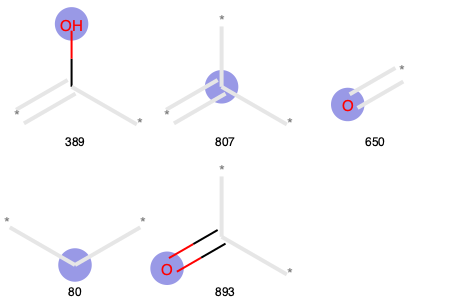

In [21]:
# https://iwatobipen.wordpress.com/2018/11/07/visualize-important-features-of-machine-leaning-rdkit/
fp, bitinfo = mol2fp(test_mols[79])
onbit = [bit for bit in bitinfo.keys()]
importantonbits = list(set(onbit) & set(top50feat))

tpls = [(test_mols[79], x, bitinfo) for x in importantonbits]
Draw.DrawMorganBits(tpls, legends = [str(x) for x in importantonbits])

True: (C) high vs Predicted: (C) high


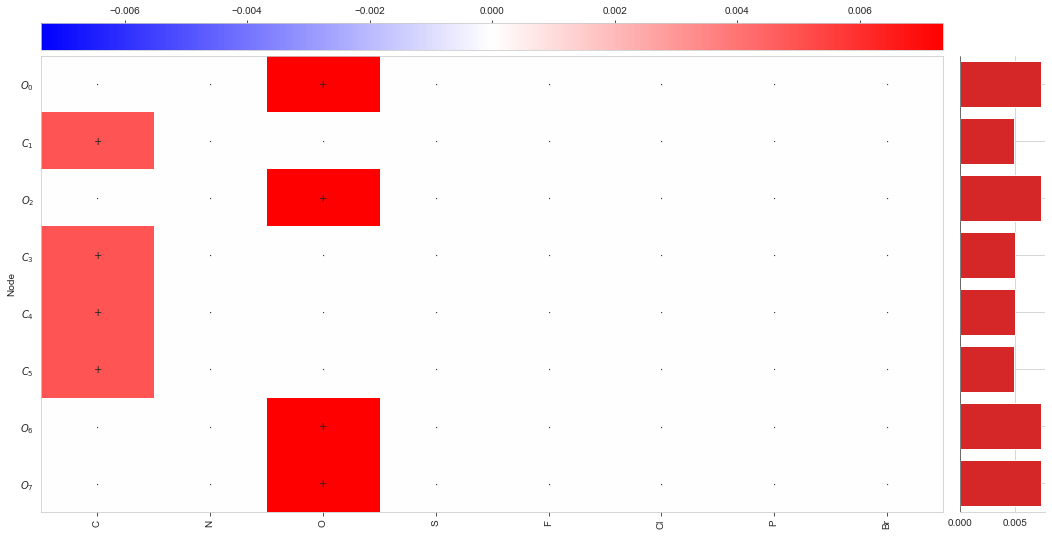

In [22]:
mol = test_mols[79]
show_pred_results(mol, clf)
weights = weights_from_feat_imp(mol, clf.feature_importances_, collided_bits='mean')
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

## SHAP

In [23]:
%%time
explainer = shap.TreeExplainer(clf, data=X_train, feature_dependence="independent")

CPU times: user 101 ms, sys: 8.72 ms, total: 110 ms
Wall time: 93.3 ms


 99%|===================| 3056/3075 [00:49<00:00]        

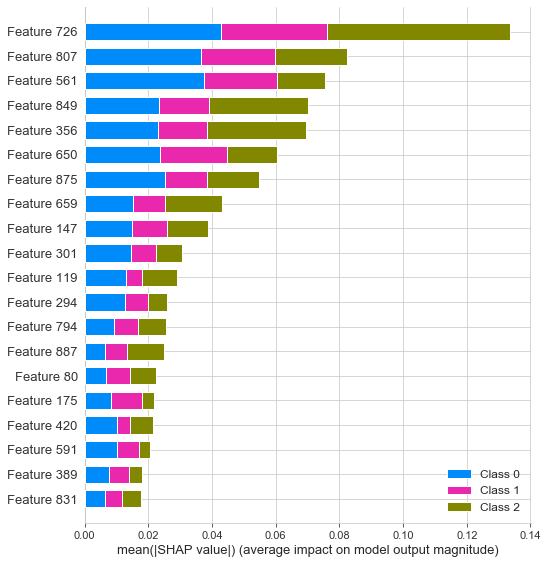

CPU times: user 48.9 s, sys: 185 ms, total: 49.1 s
Wall time: 49 s


In [24]:
%%time
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

 99%|===================| 762/771 [00:13<00:00]        

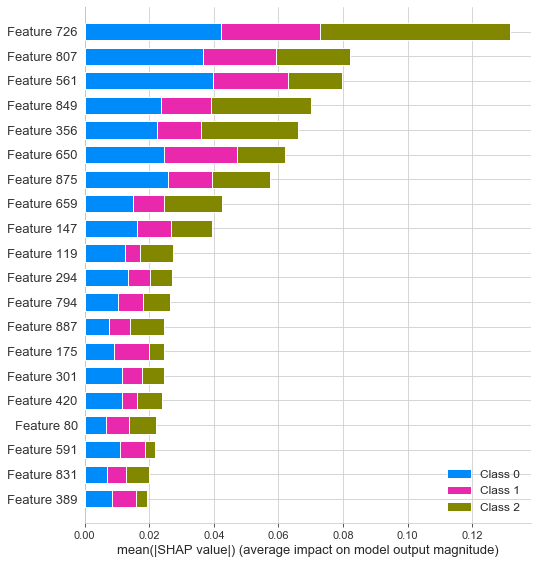

CPU times: user 13.3 s, sys: 70.7 ms, total: 13.4 s
Wall time: 12.8 s


In [25]:
%%time
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

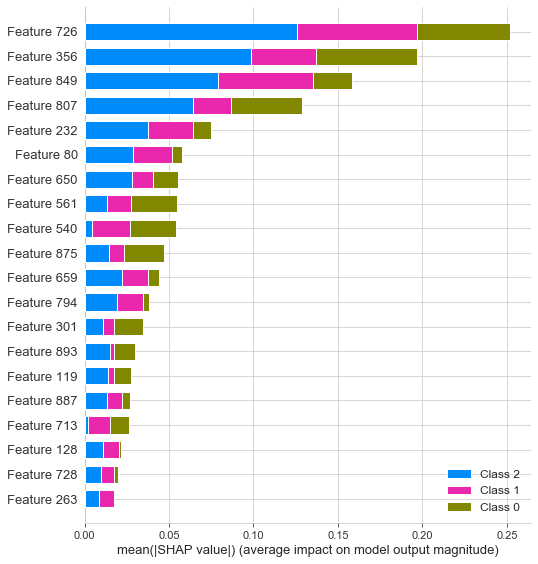

CPU times: user 387 ms, sys: 8.76 ms, total: 396 ms
Wall time: 394 ms


In [26]:
%%time
shap_values = explainer.shap_values(mol2fp(test_mols[79], nBits=1024)[0].reshape((1,-1)))
shap.summary_plot(shap_values, mol2fp(test_mols[79], nBits=1024)[0].reshape((1,-1)))

In [27]:
def weight_from_shap_values(mol, model, class_id=2, collided_bits='mean'):
    fp, bitinfo = mol2fp(mol)
    weights = np.zeros(mol.GetNumAtoms(), ) 
    # TreeExplainerのインスタンスを立ち上げるときにclfのみを与えると後にエラーが出る
    explainer = shap.TreeExplainer(clf, data=X_train, feature_dependence="independent")
    shap_values = explainer.shap_values(fp.reshape((1,-1)))[class_id]
    for bit, infos in bitinfo.items():
        for atom_infos in infos:
            if collided_bits == 'mean':            
                weights[atom_infos[0]] += shap_values[0, bit]/ len(infos)
            else:
                weights[atom_infos[0]] += shap_values[0, bit]
    return weights

True: (C) high vs Predicted: (C) high


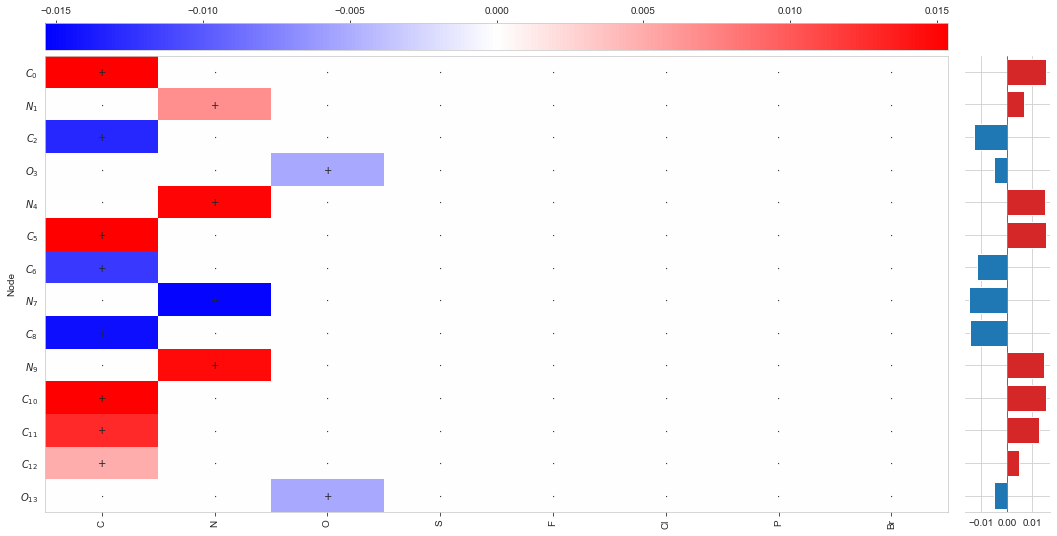

In [28]:
mol = test_mols[141]
show_pred_results(mol, clf)
weights = weight_from_shap_values(mol, clf, class_id=2, collided_bits='mean')
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

True: (C) high vs Predicted: (C) high


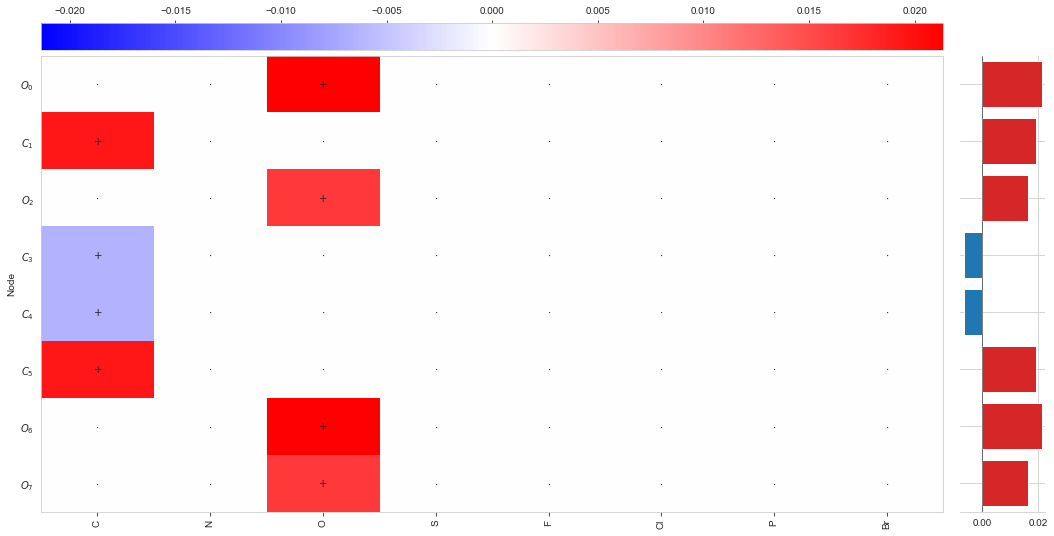

In [29]:
mol = test_mols[79]
show_pred_results(mol, clf)
weights = weight_from_shap_values(mol, clf, class_id=2, collided_bits='mean')
plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

True: (C) high vs Predicted: (B) medium


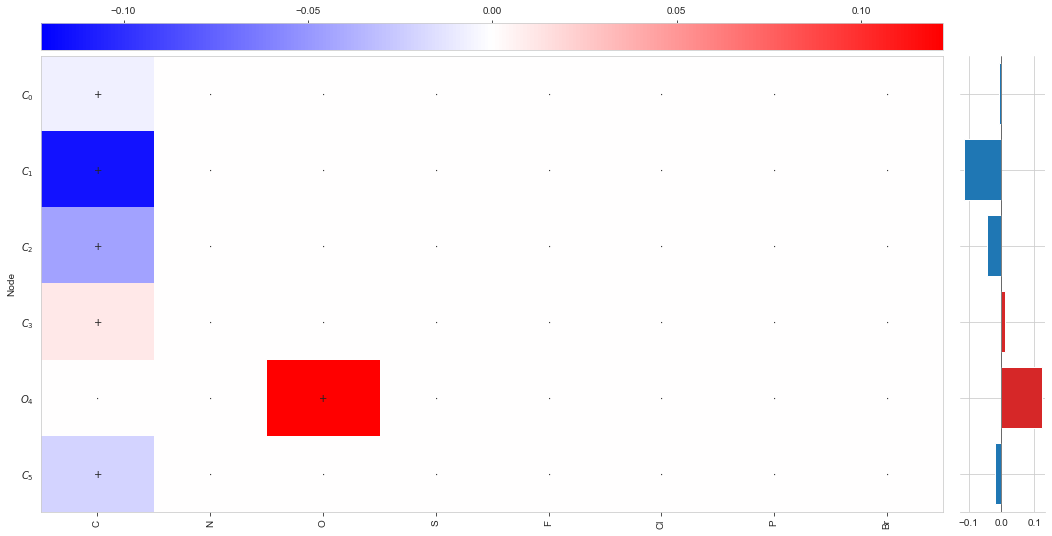

True: (C) high vs Predicted: (C) high


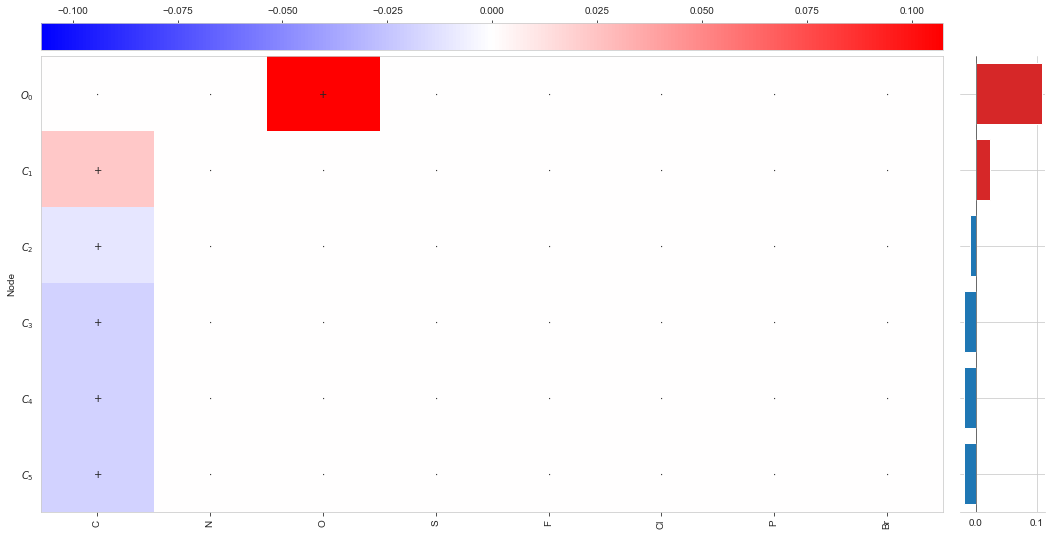

True: (C) high vs Predicted: (C) high


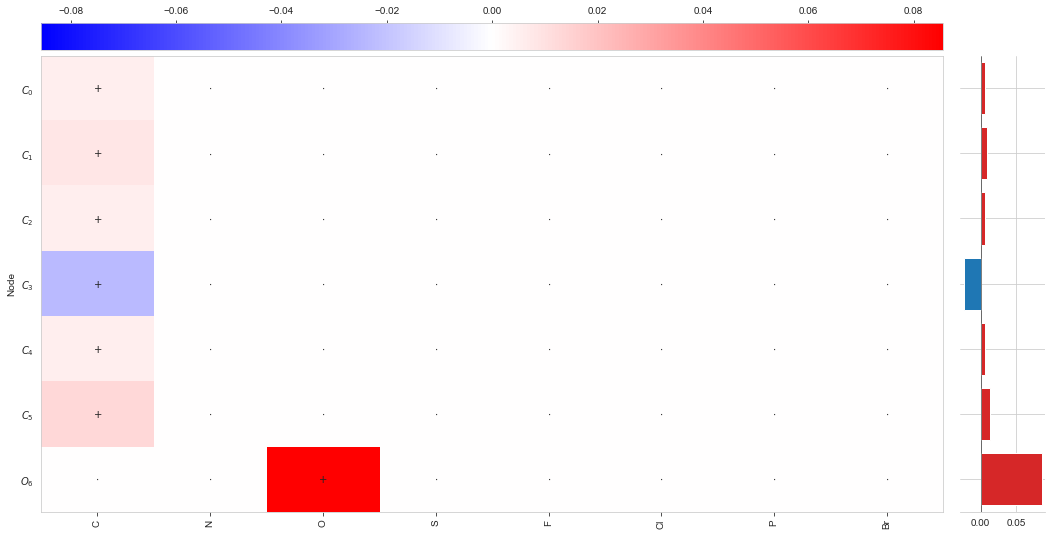

True: (C) high vs Predicted: (C) high


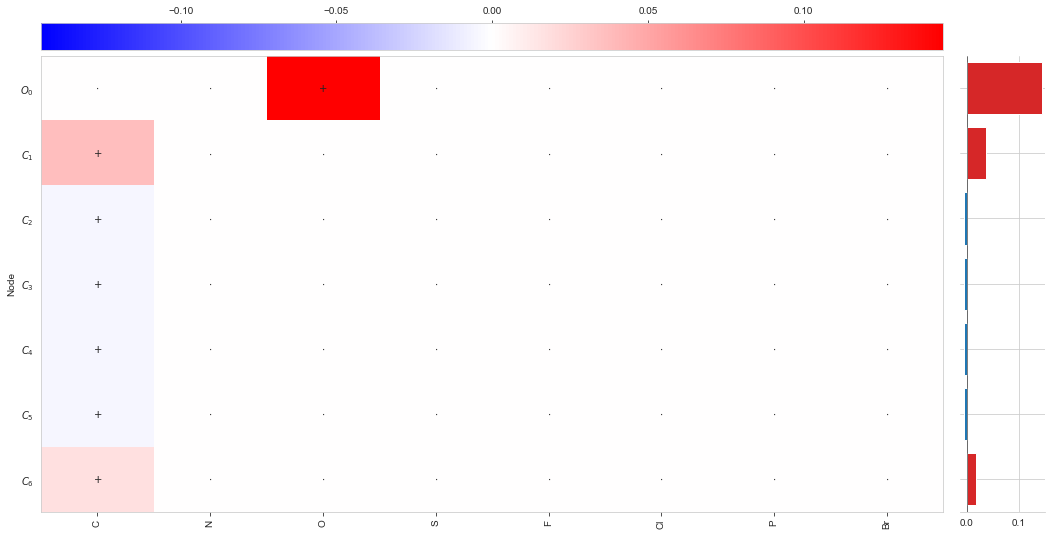

True: (C) high vs Predicted: (C) high


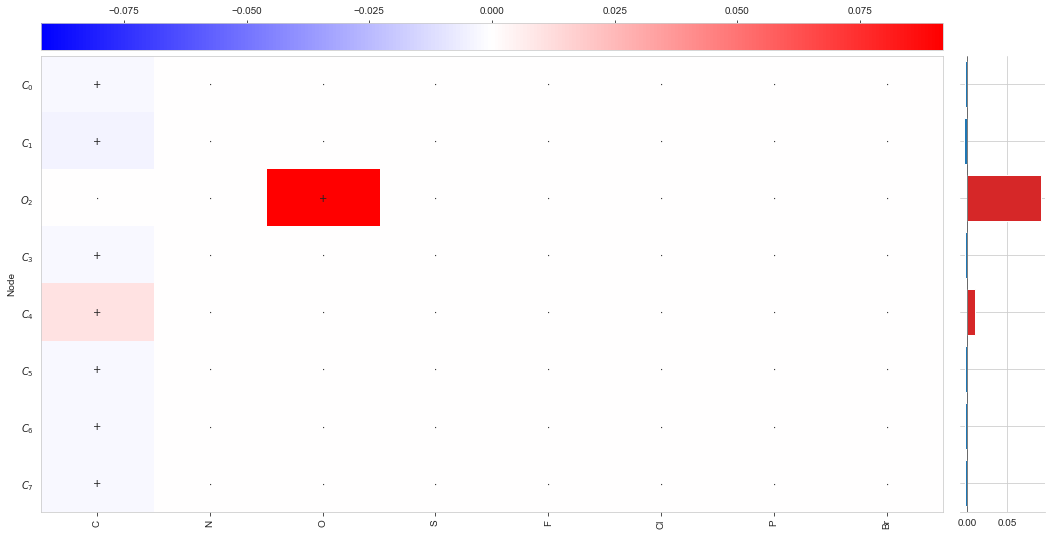

True: (C) high vs Predicted: (C) high


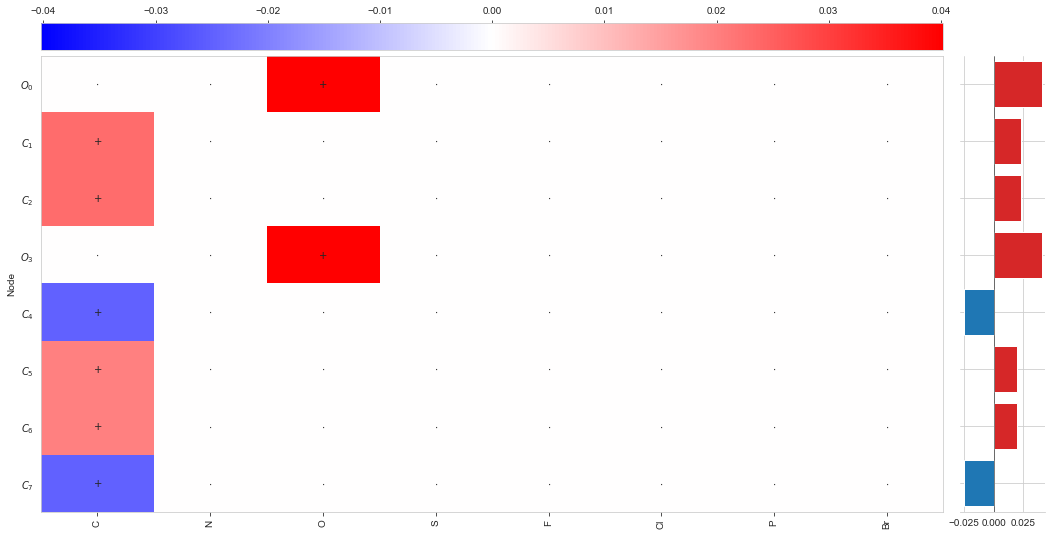

True: (C) high vs Predicted: (B) medium


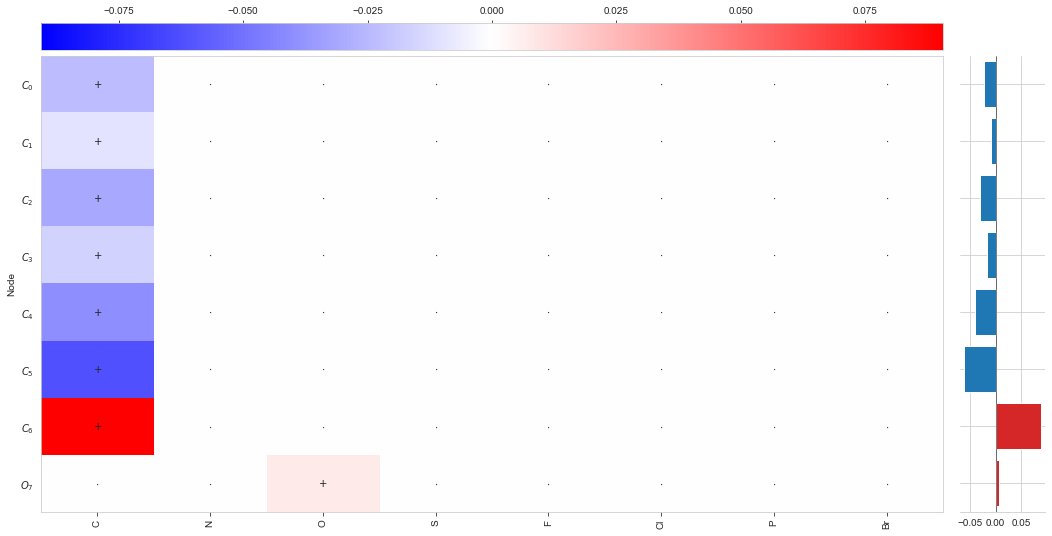

True: (C) high vs Predicted: (C) high


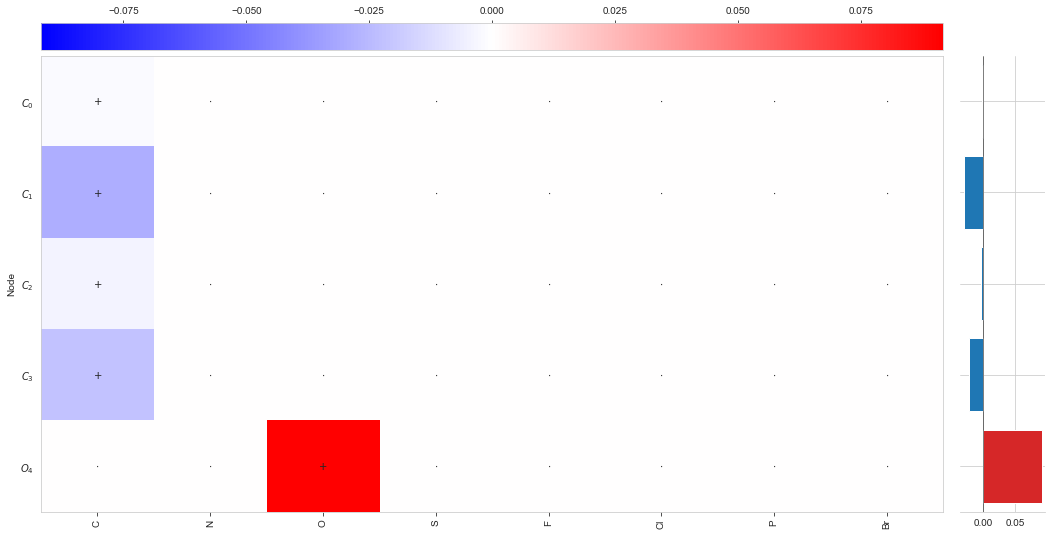

True: (C) high vs Predicted: (B) medium


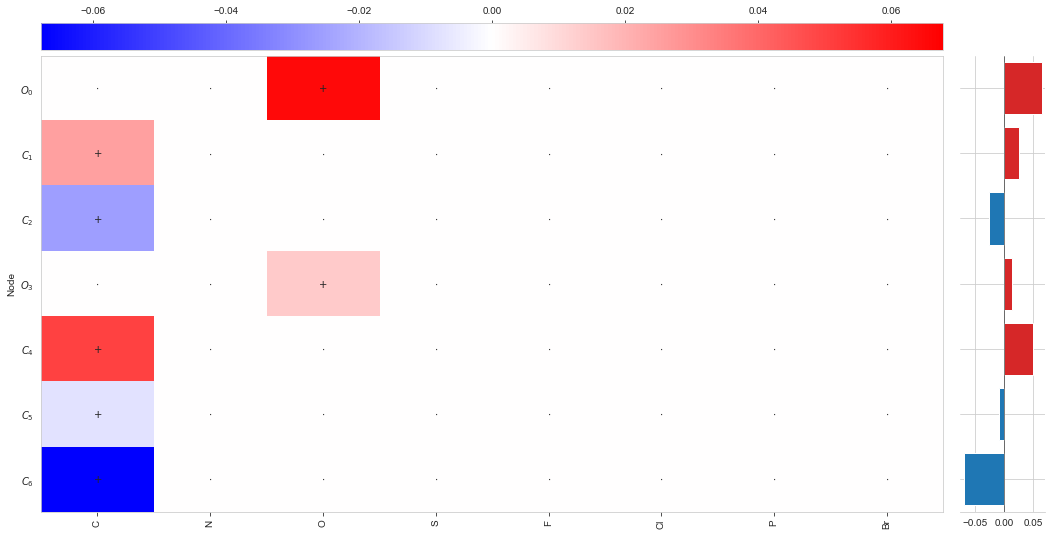

True: (C) high vs Predicted: (A) low


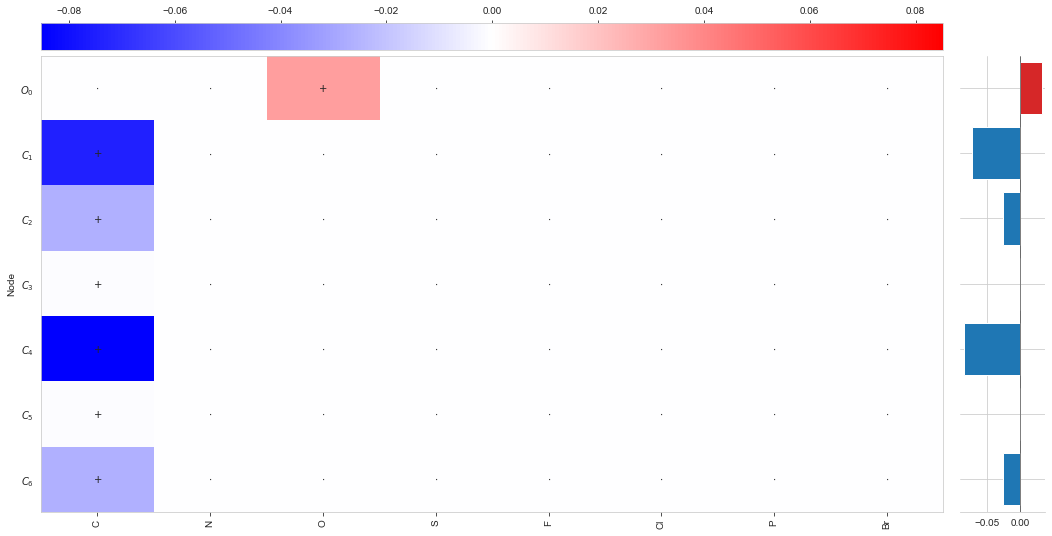

True: (C) high vs Predicted: (B) medium


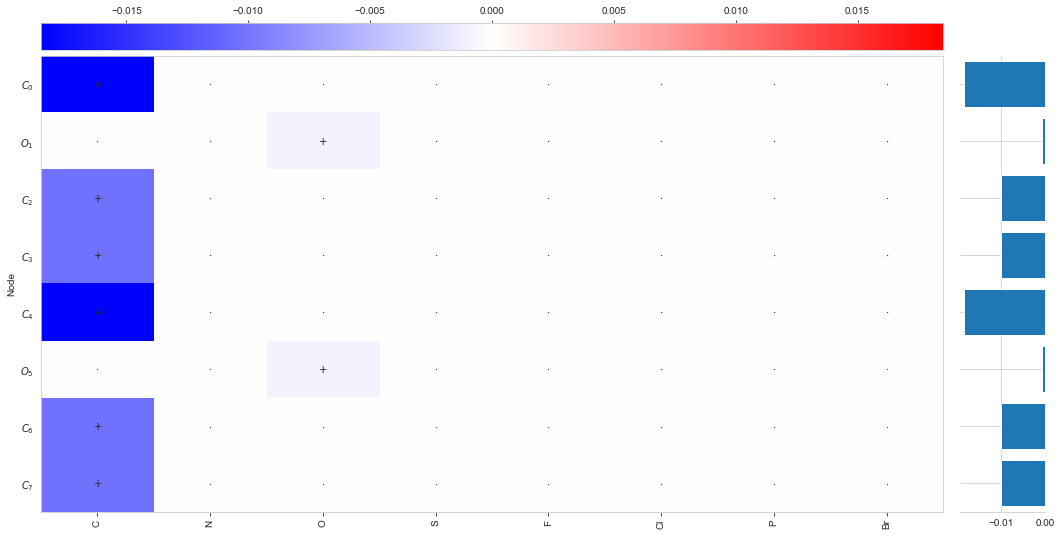

True: (C) high vs Predicted: (C) high


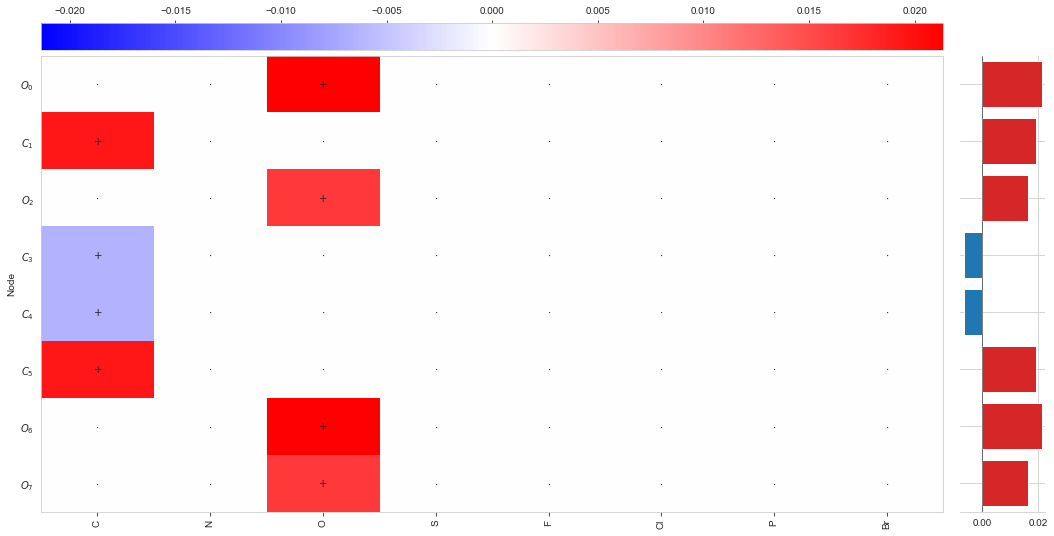

True: (C) high vs Predicted: (C) high


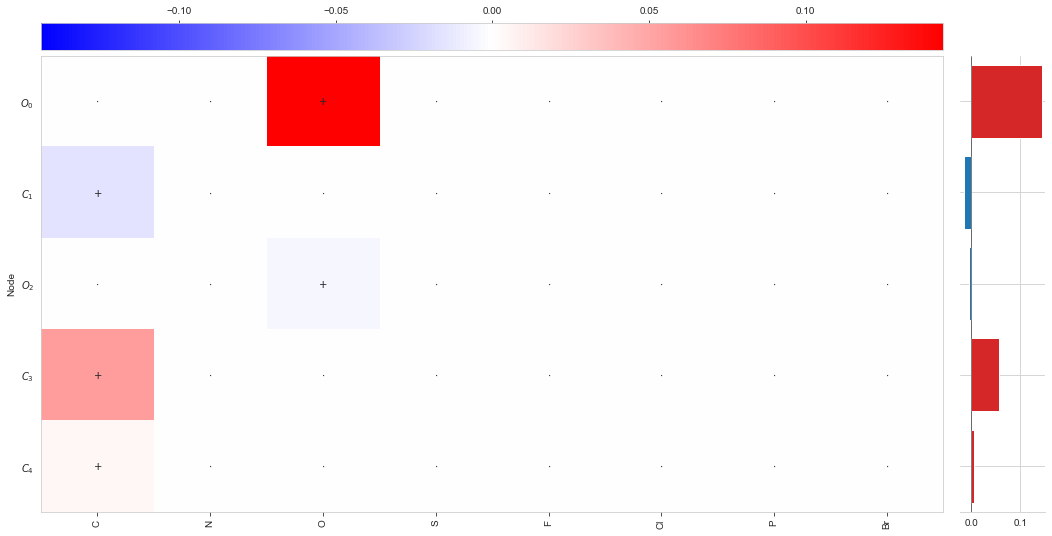

True: (C) high vs Predicted: (C) high


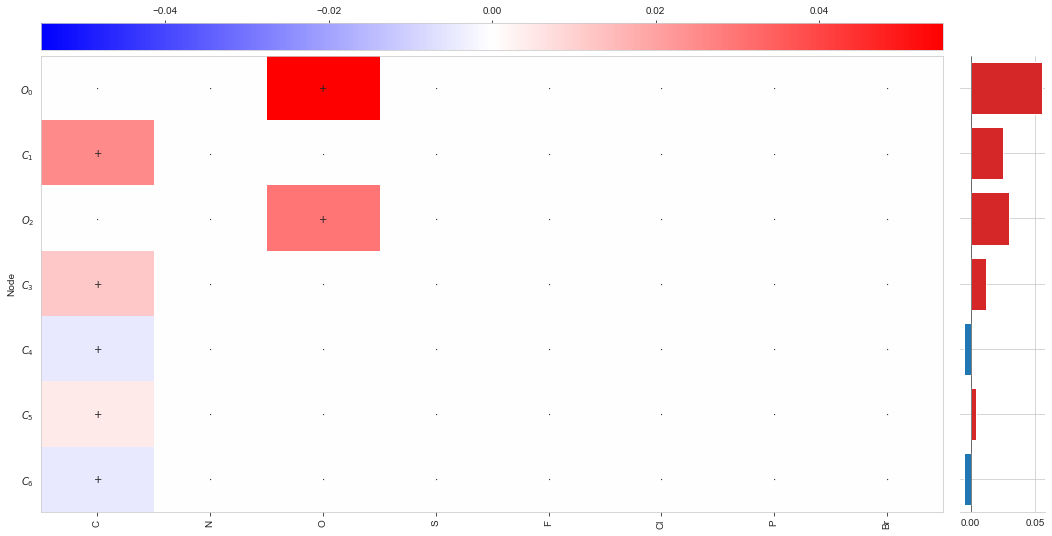

True: (C) high vs Predicted: (C) high


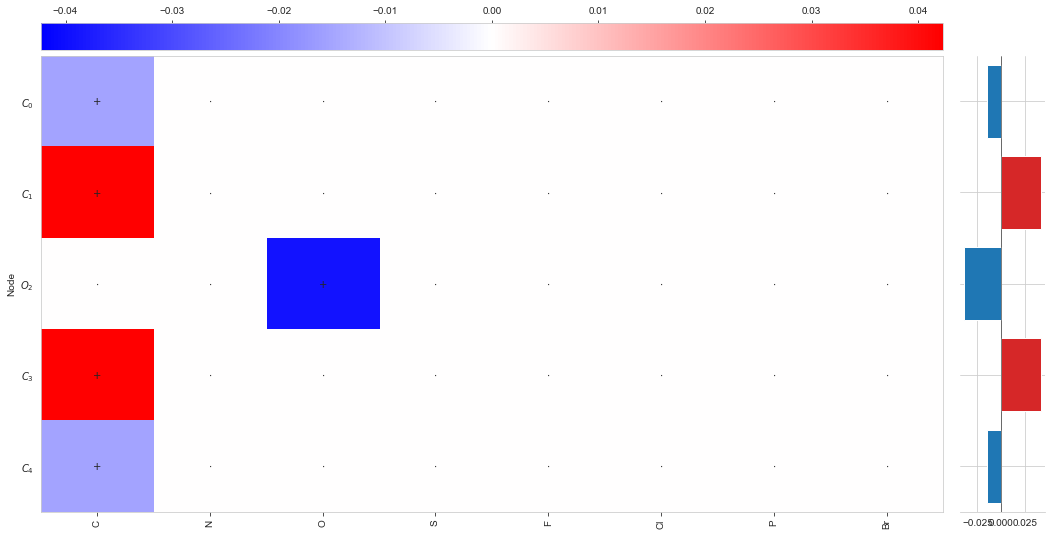

True: (C) high vs Predicted: (C) high


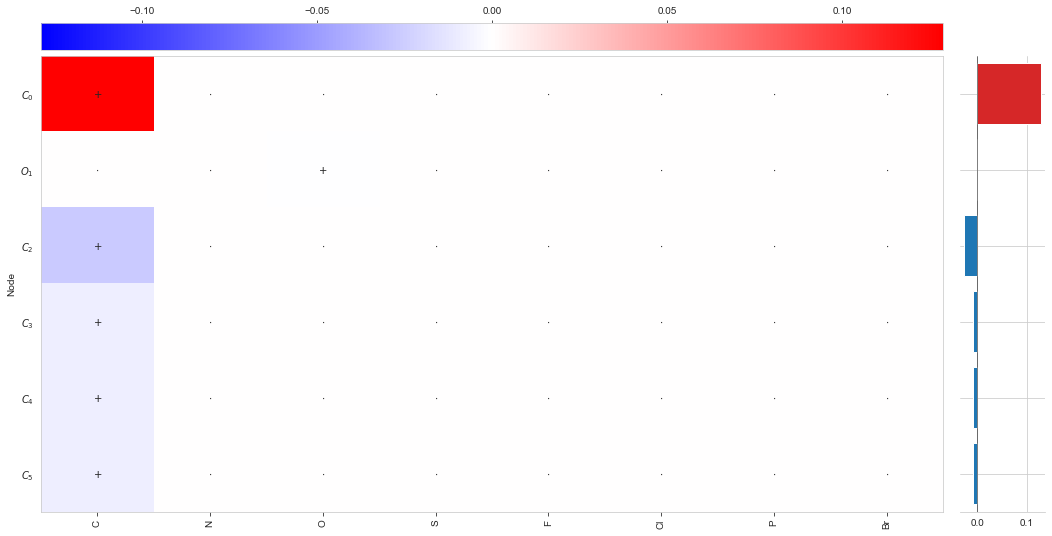

True: (C) high vs Predicted: (C) high


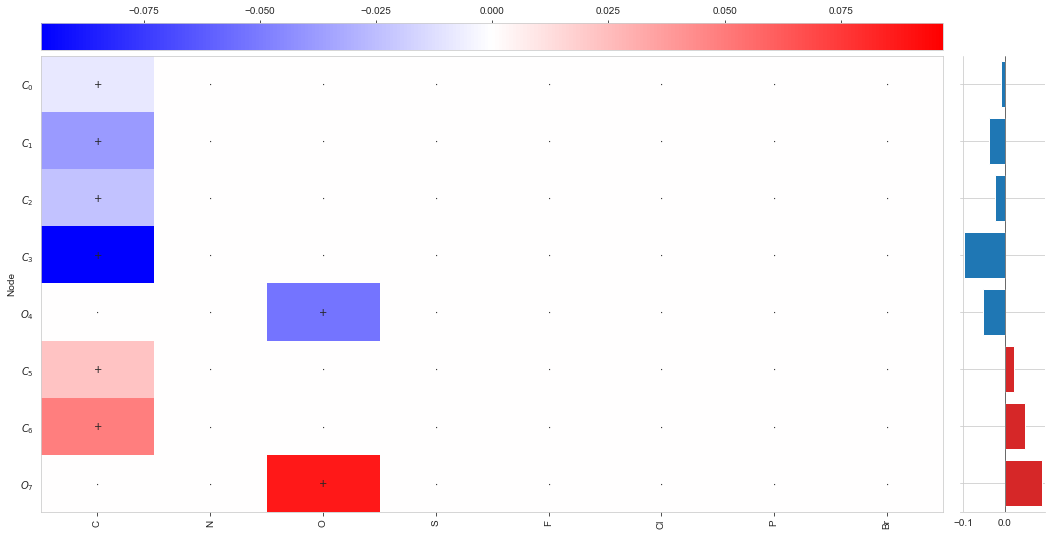

True: (C) high vs Predicted: (B) medium


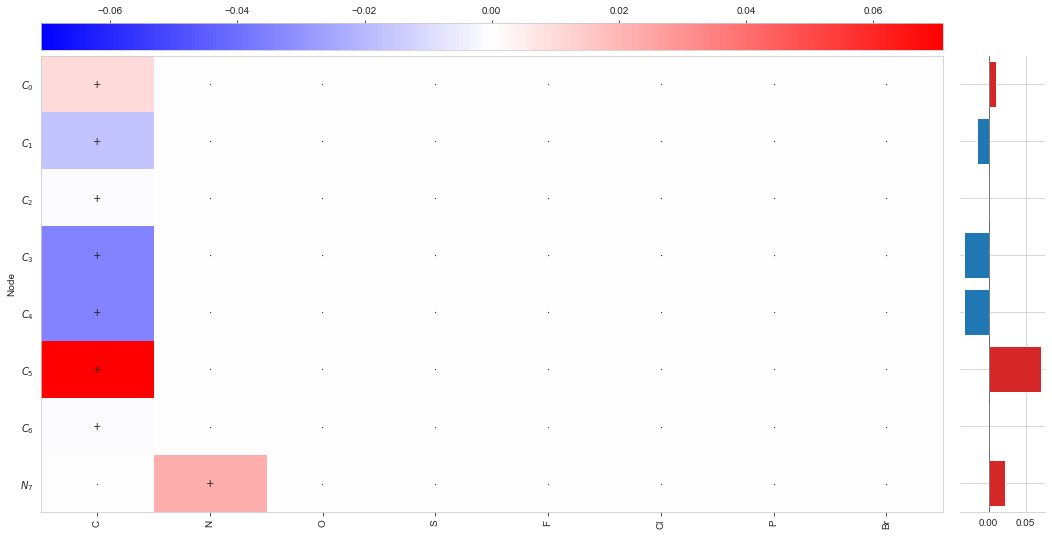

True: (C) high vs Predicted: (C) high


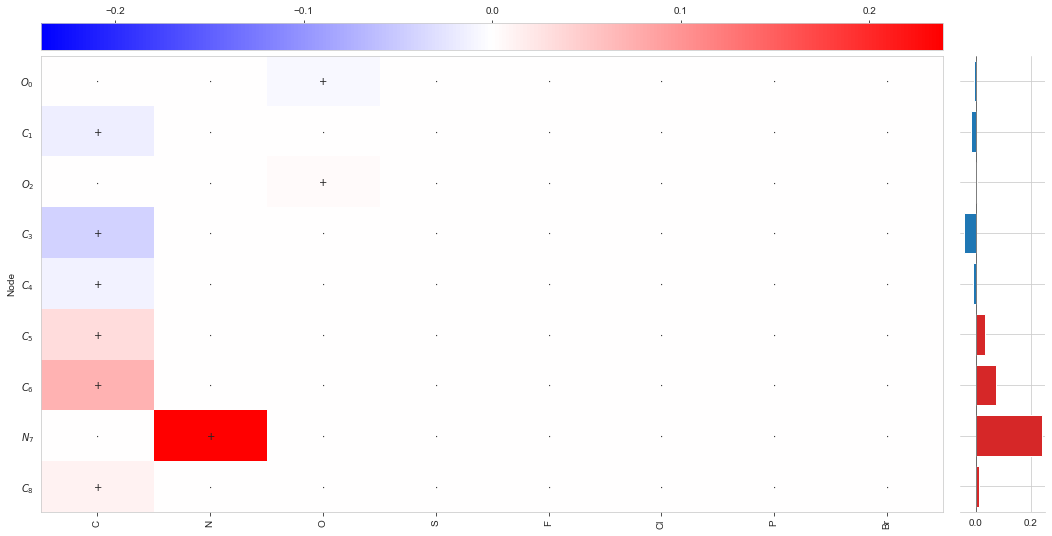

True: (C) high vs Predicted: (C) high


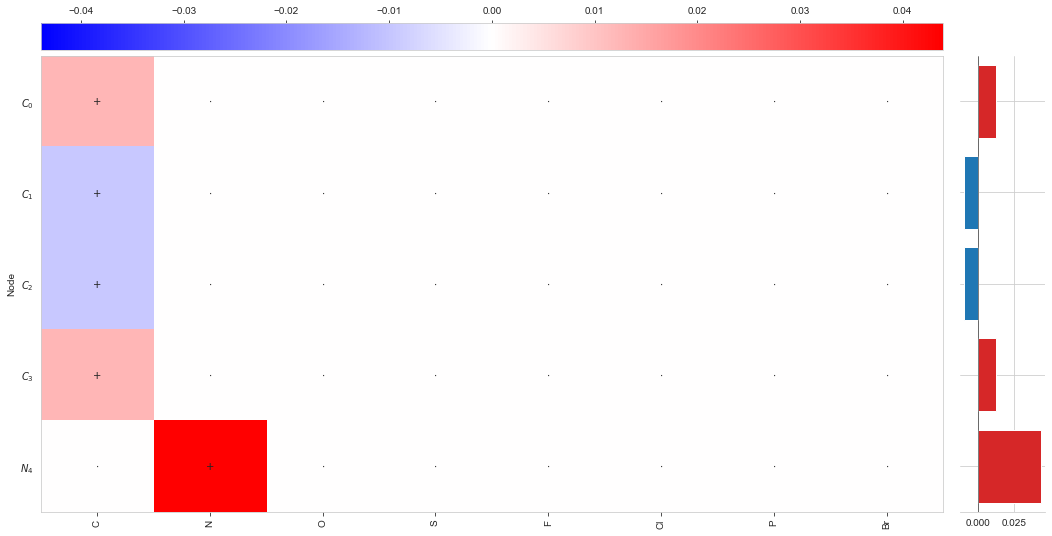

True: (C) high vs Predicted: (B) medium


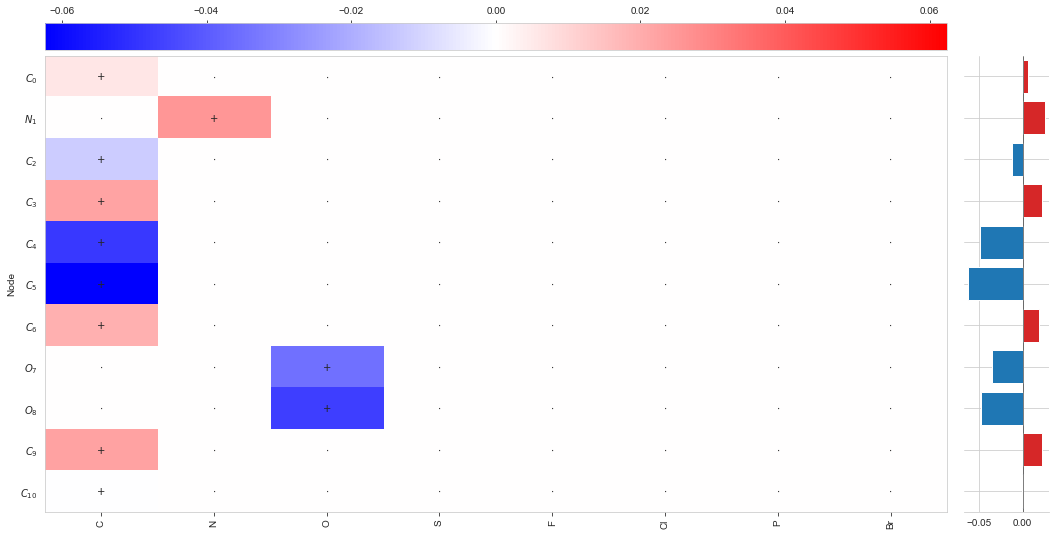

True: (C) high vs Predicted: (C) high


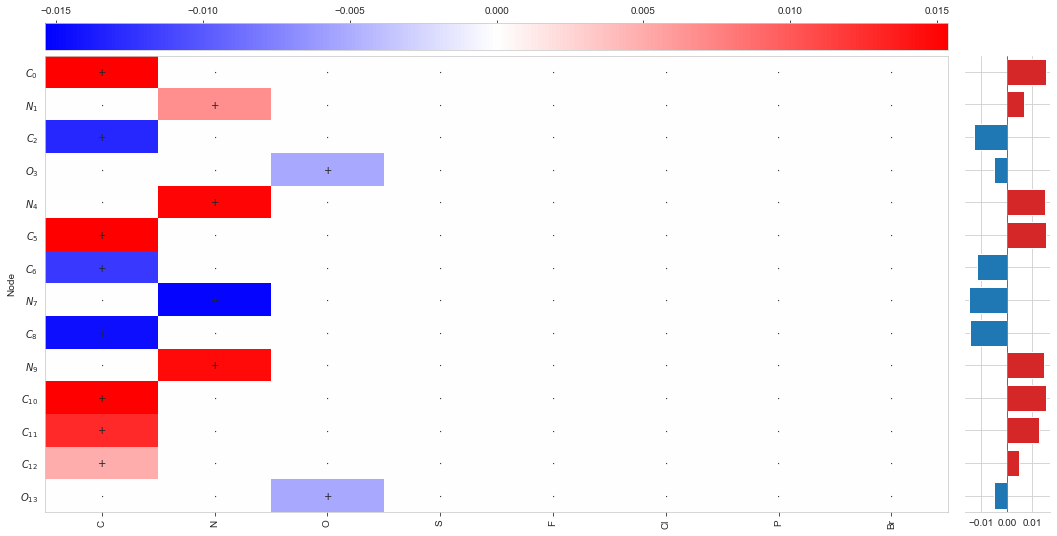

True: (C) high vs Predicted: (C) high


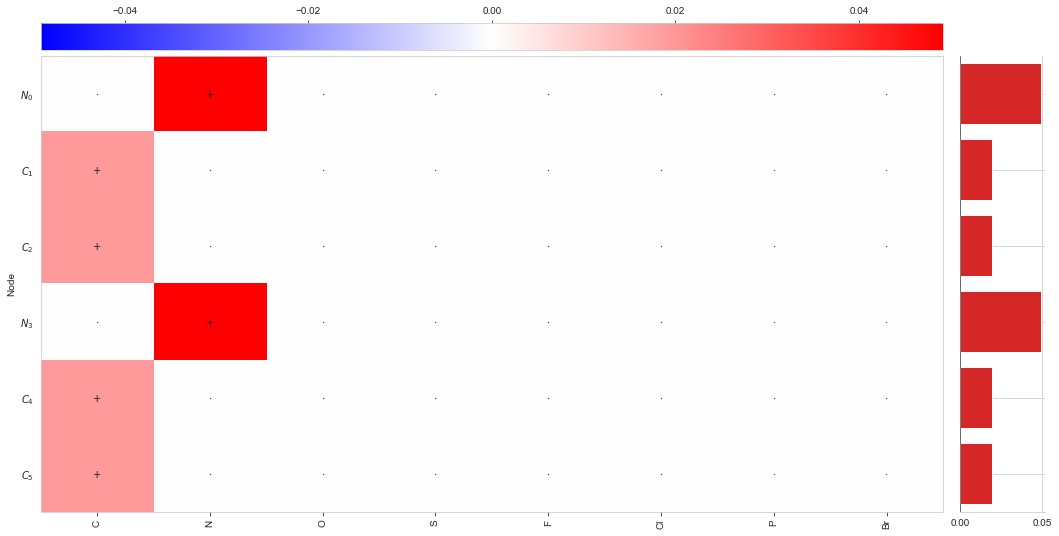

True: (C) high vs Predicted: (C) high


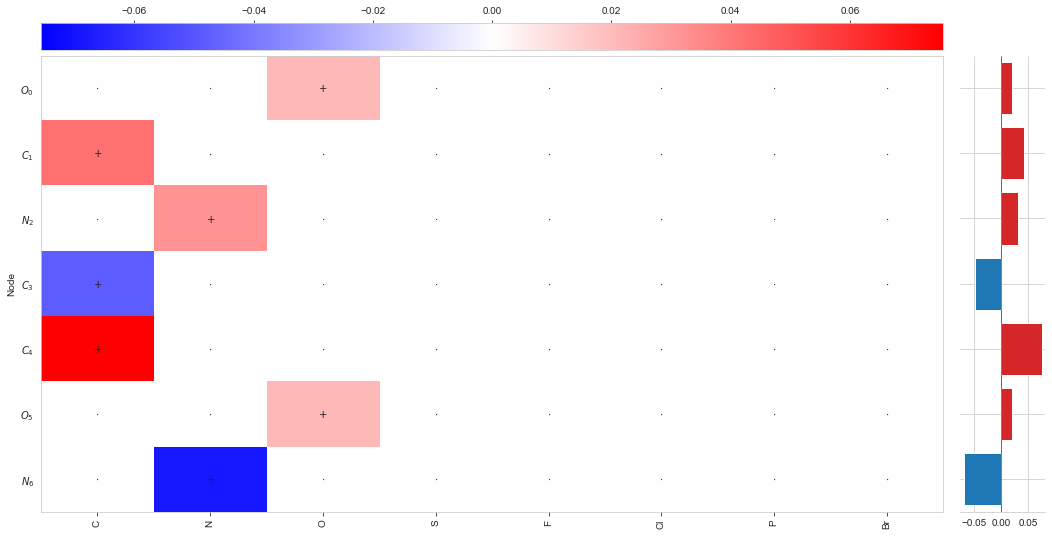

True: (C) high vs Predicted: (C) high


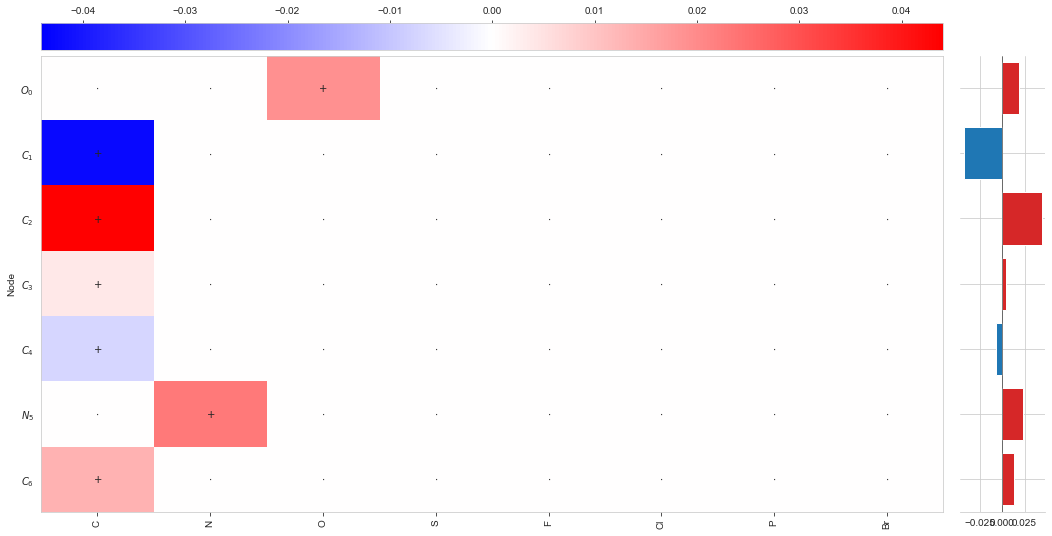

True: (C) high vs Predicted: (C) high


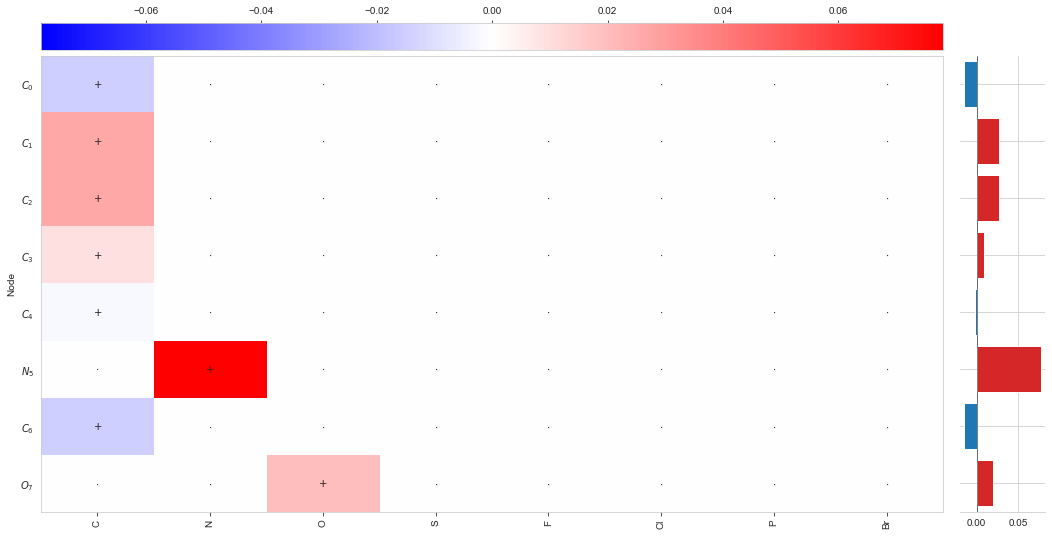

True: (C) high vs Predicted: (C) high


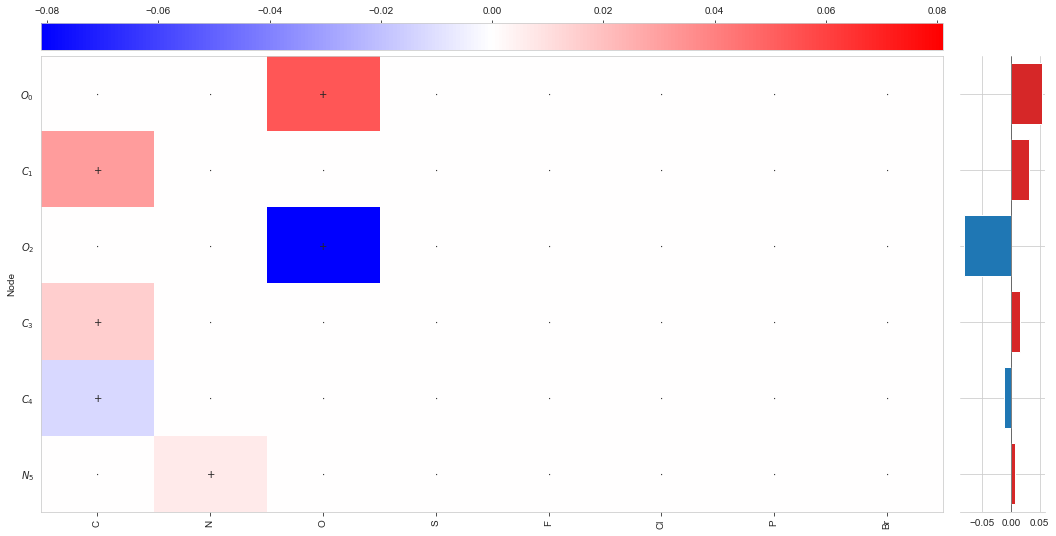

True: (C) high vs Predicted: (C) high


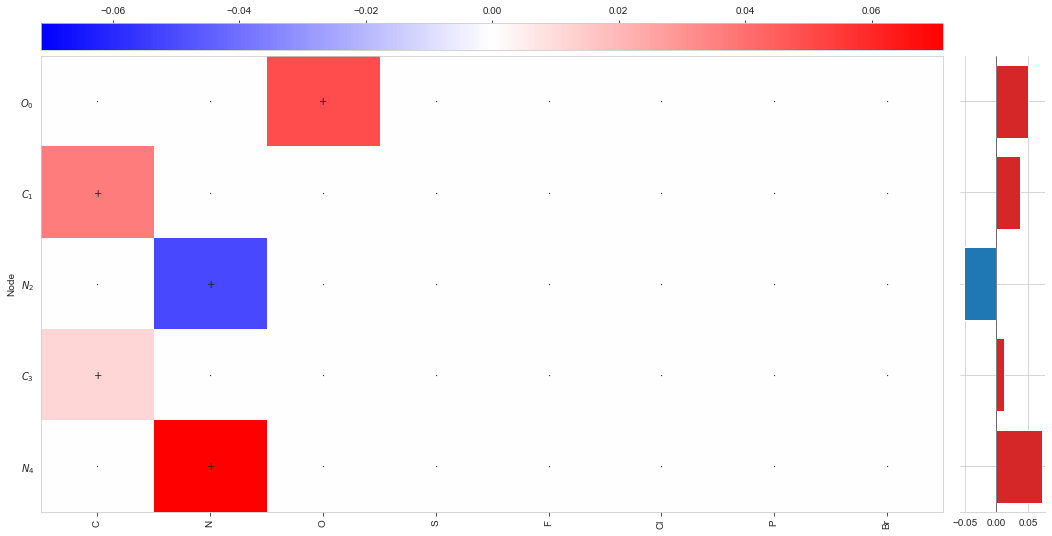

True: (C) high vs Predicted: (C) high


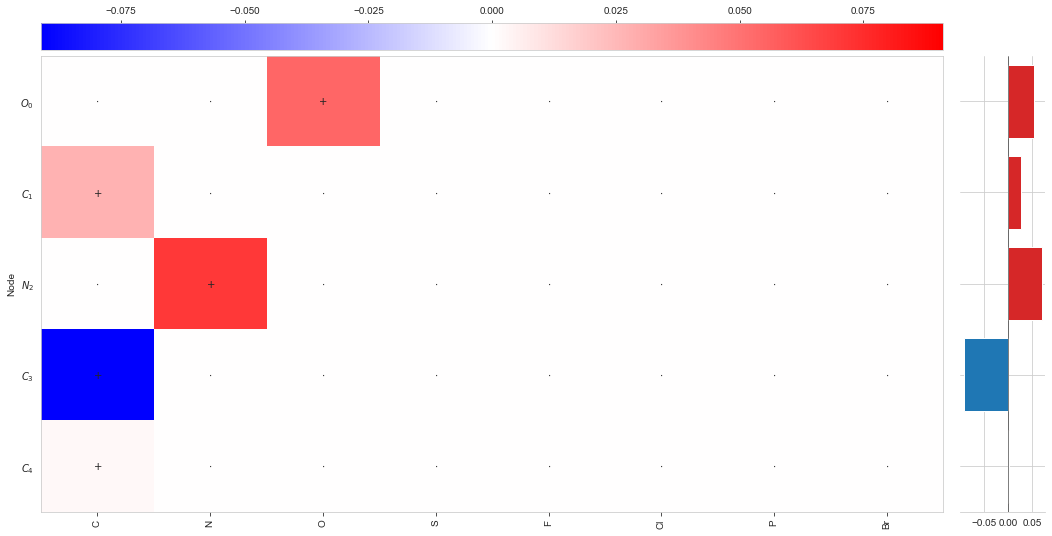

True: (C) high vs Predicted: (B) medium


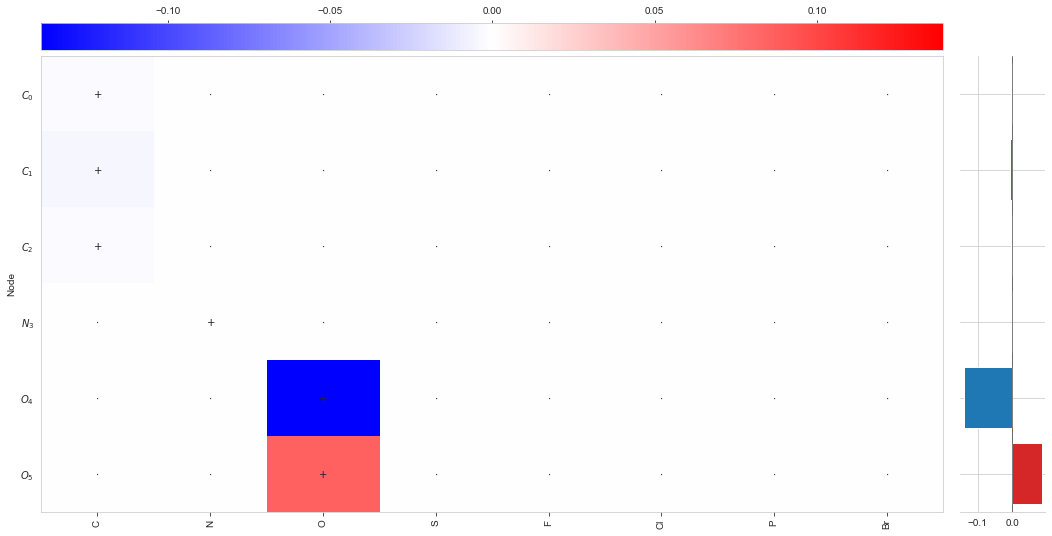

True: (C) high vs Predicted: (B) medium


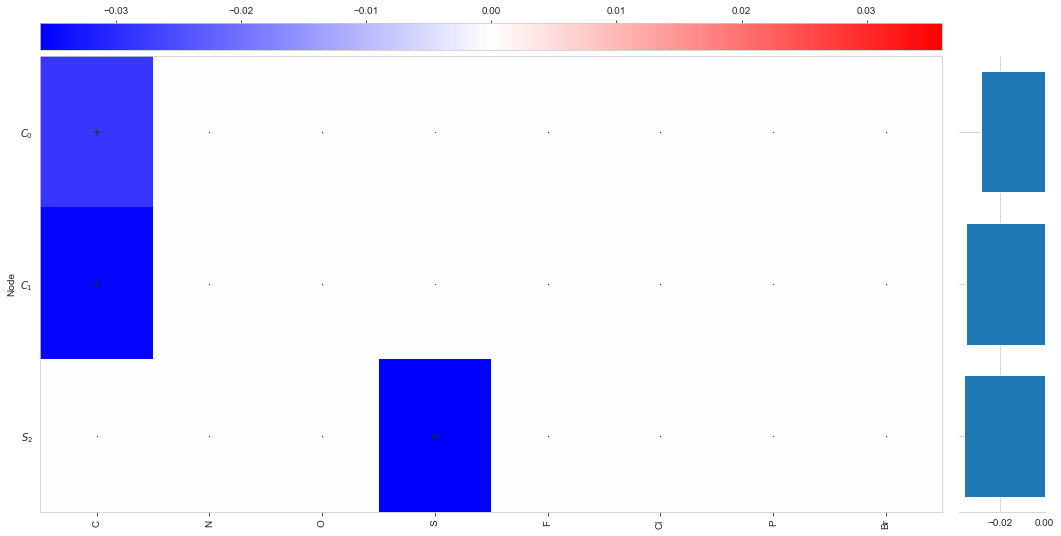

True: (C) high vs Predicted: (C) high


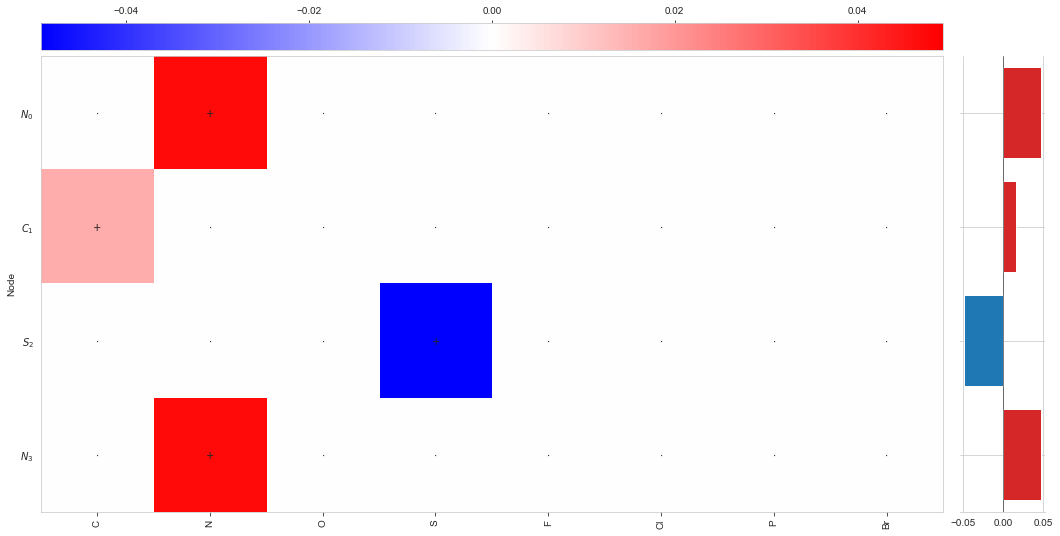

True: (C) high vs Predicted: (C) high


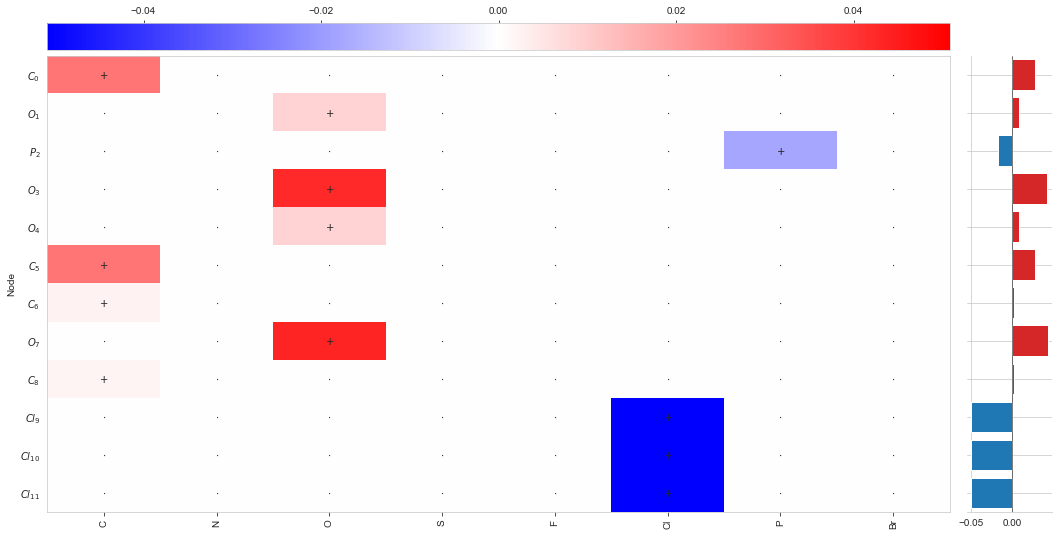

True: (C) high vs Predicted: (C) high


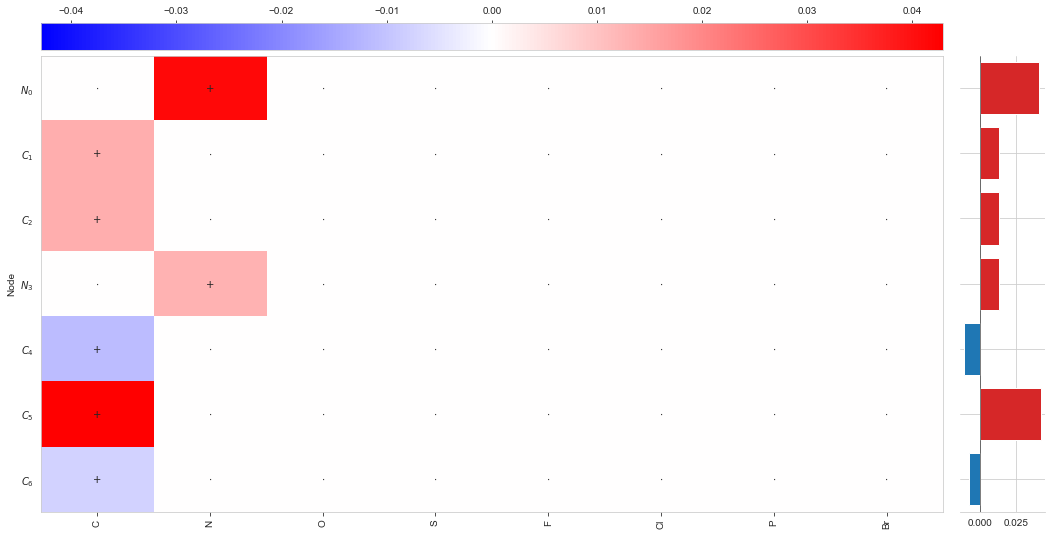

True: (C) high vs Predicted: (C) high


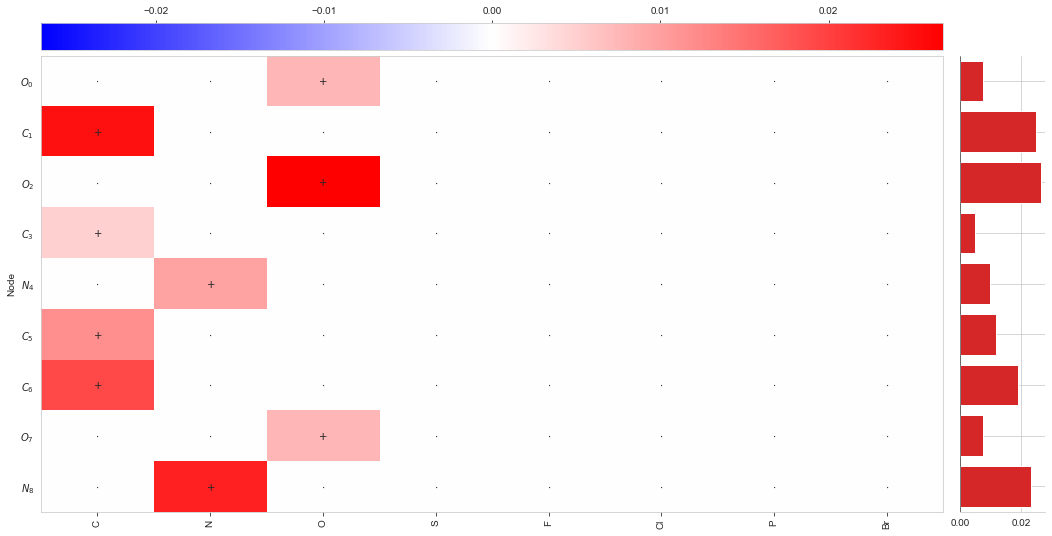

True: (C) high vs Predicted: (C) high


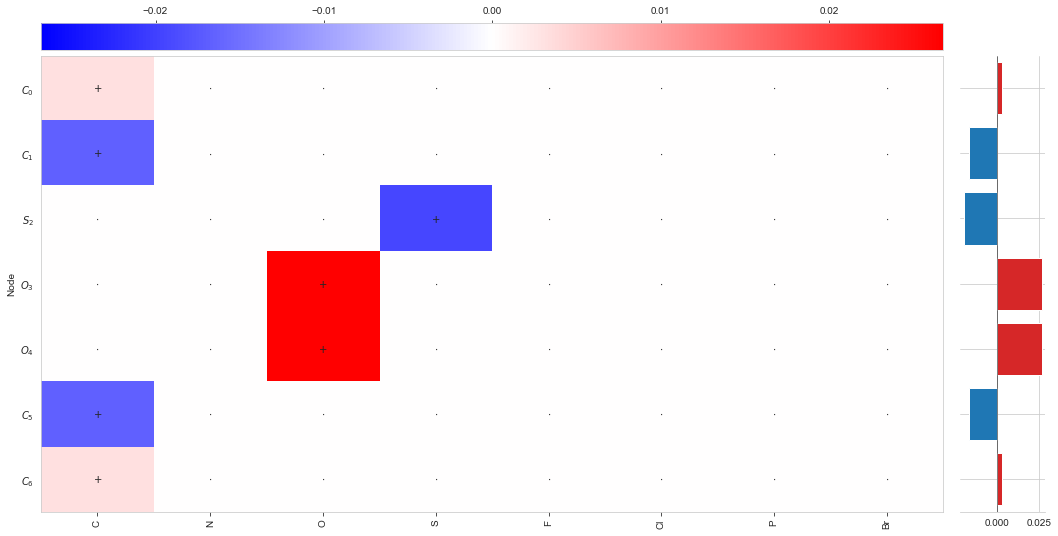

True: (C) high vs Predicted: (C) high


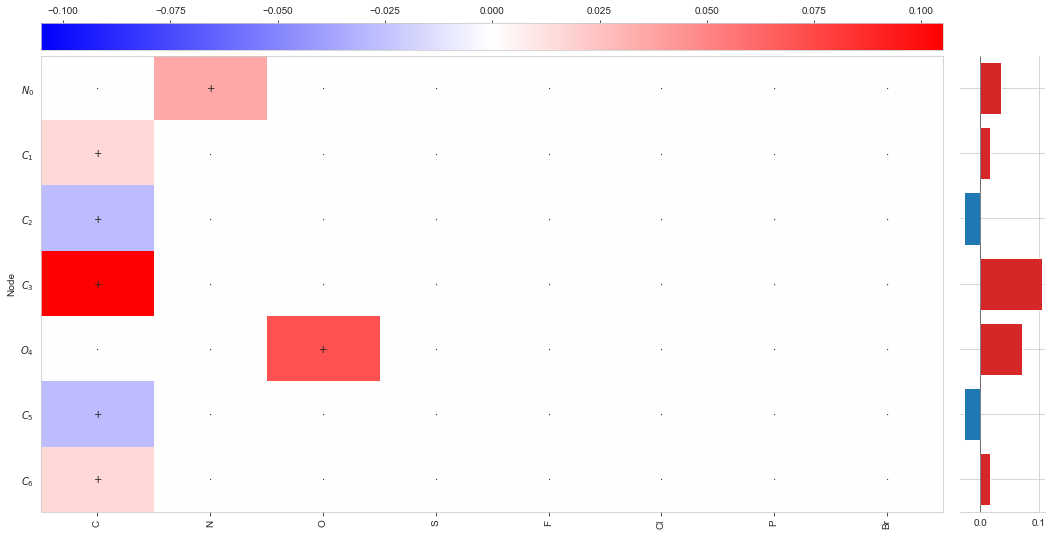

True: (C) high vs Predicted: (C) high


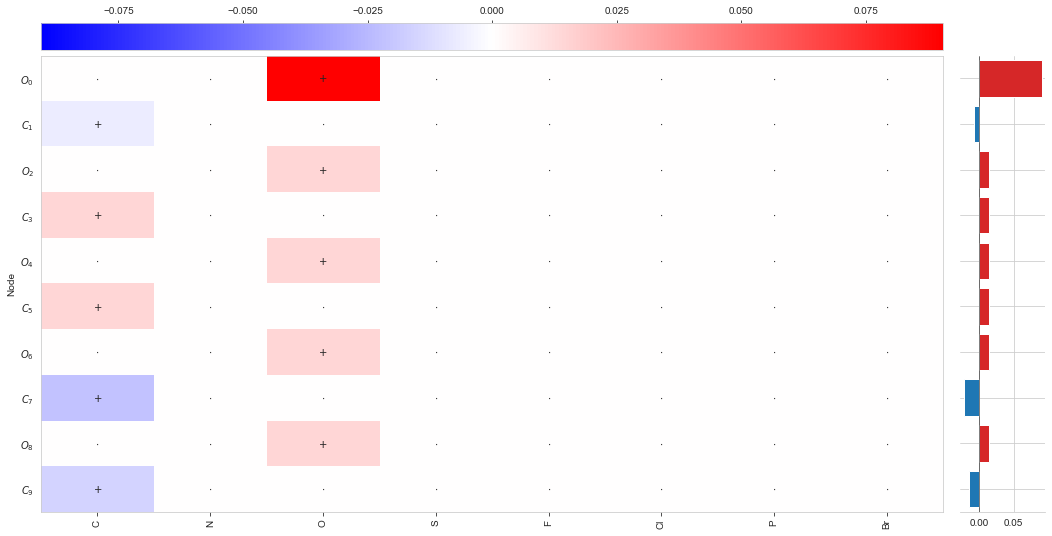

True: (C) high vs Predicted: (C) high


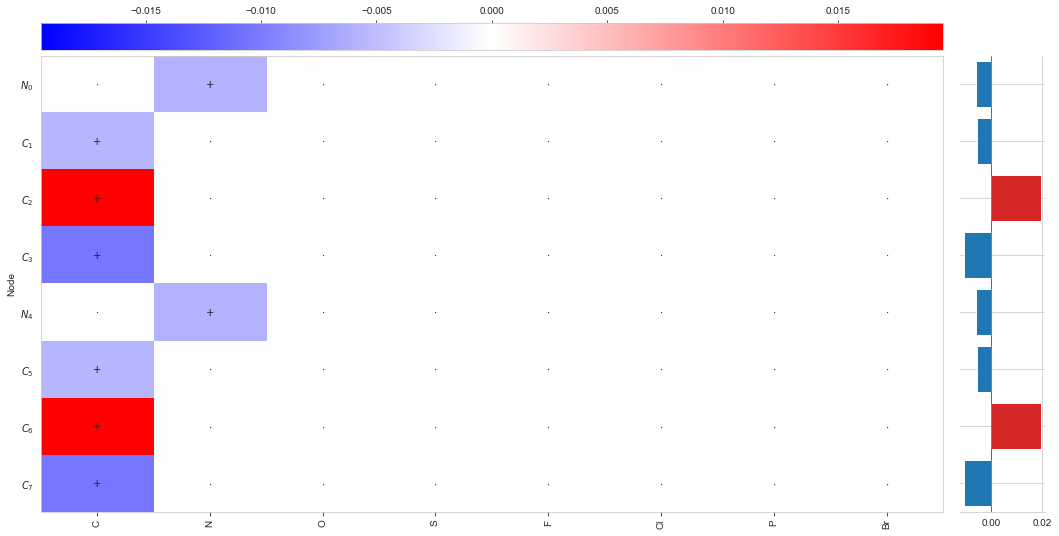

True: (C) high vs Predicted: (C) high


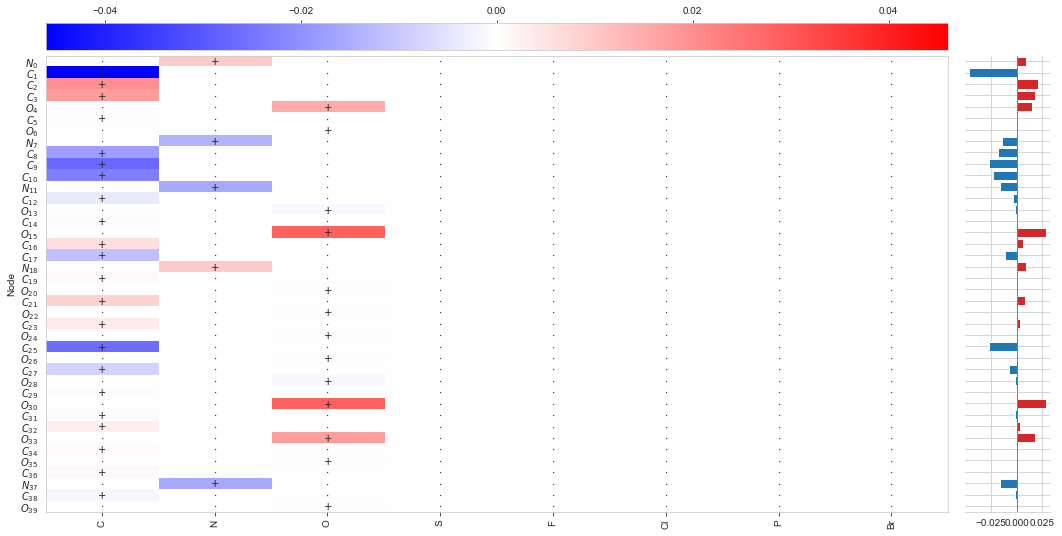

Total 40 cpds have been shown.


In [30]:
# Class = 2のTestデータのみ可視化
n = 0
for mol in test_mols:
    if sol_classes[mol.GetProp('SOL_classification')]==2:
        n += 1
        show_pred_results(mol, clf)
        weights = weight_from_shap_values(mol, clf, class_id=2, collided_bits='mean')
        plot_explainable_images(mol, weight_fn=None, weights=weights, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])
        
print(f'Total {n} cpds have been shown.')